In [10]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
import os

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",google_api_key=GEMINI_API_KEY )


In [ ]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, SystemMessage
# from langchain_core.utils.function_calling import add_messages
from operator import add as add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]



def app_stream(content):
    print("🌀 State:", content)


@tool
def run_phq9_assessment() -> dict:
    """Run PHQ-9 depression screening assessment FOR user if it is needed"""
    print("🔧 Running PHQ-9 Assessment")
    questions = [
        "Over the last 2 weeks, how often have you felt little interest or pleasure in doing things?",
        "How often have you felt down, depressed, or hopeless?",
        "How often have you had trouble falling or staying asleep?"
    ]
    answers = []
    for q in questions:
        print("🤖:", q)
        a = input("You: ")
        answers.append(a)
    score = sum(3 for a in answers if "yes" in a.lower() or "often" in a.lower())
    return {"tool_name": "PHQ9", "score": score}


@tool
def run_gad7_assessment() -> dict:
    """Run GAD-7 anxiety screening assessment FOR user if it is needed"""

   

    print("🔧 Running GAD-7 Assessment")
    questions = [
        "Have you been feeling nervous or on edge?",
        "Do you find it difficult to stop worrying?",
        "Do you feel easily irritated?"
    ]
    answers = []
    for q in questions:
        print("🤖:", q)
        a = input("You: ")
        answers.append(a)
    score = sum(3 for a in answers if "yes" in a.lower() or "often" in a.lower())
    return {"tool_name": "GAD7", "score": score}


tools = [run_phq9_assessment, run_gad7_assessment]

llm_with_tools = llm.bind_tools(tools)



def emotional_check_in_node(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(
        content="You are a compassionate emotional helper  assistant. Note that If the user needs further help, call an appropriate assessment tool[run_phq9_assessment or run_gad7_assessment]." #Do not call the tool at the start , call only the if you feel that user need to be assessed with tools  "
    )
    response = llm_with_tools.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}



def should_continue(state: AgentState) -> str:
    last = state["messages"][-1]
    if not getattr(last, "tool_calls", None):
        return "end"
    return "continue"



builder = StateGraph(AgentState)

# Tool Node
tool_node = ToolNode(tools=tools)
builder.add_node("PHQ9/GAD-7 TOOLS", tool_node)

builder.add_node("emotional_check_in_node", emotional_check_in_node)

builder.add_edge("PHQ9/GAD-7 TOOLS", "emotional_check_in_node")
builder.add_conditional_edges(
    "emotional_check_in_node",
    should_continue,
    {
        "continue": "PHQ9/GAD-7 TOOLS",
        "end": END,
    }
)

builder.set_entry_point("emotional_check_in_node")



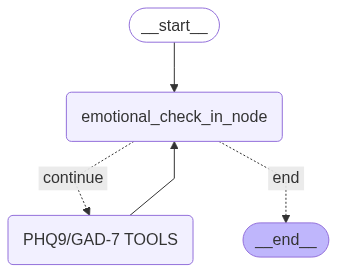

In [29]:
builder.compile()


In [40]:
graph = builder.compile()


In [ ]:



initial_state: AgentState = {
    "messages": [("user", "Hi run phq9 test for me now pleae")]
}

for step in graph.stream(initial_state):
    app_stream(step)

🌀 State: {'emotional_check_in_node': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'run_phq9_assessment', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--b9fccfda-990a-4f60-86fd-3234a85b8db4-0', tool_calls=[{'name': 'run_phq9_assessment', 'args': {}, 'id': '523b8b8e-7c18-4862-bd56-1ee311619318', 'type': 'tool_call'}])]}}
🔧 Running PHQ-9 Assessment
🤖: Over the last 2 weeks, how often have you felt little interest or pleasure in doing things?
🤖: How often have you felt down, depressed, or hopeless?
🤖: How often have you had trouble falling or staying asleep?
🌀 State: {'PHQ9/GAD-7 TOOLS': {'messages': [ToolMessage(content='{"tool_name": "PHQ9", "score": 9}', name='run_phq9_assessment', tool_call_id='523b8b8e-7c18-4862-bd56-1ee311619318')]}}
🌀 State: {'emotional_check_in_node': {'messages': [AIMessage(content="Yo

In [ ]:



initial_state: AgentState = {
    "messages": [("user", "Hi run GAD-7 test for me now pleae")]
}

for step in graph.stream(initial_state):
    app_stream(step)

🌀 State: {'emotional_check_in_node': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'run_gad7_assessment', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--9200b345-b0d7-416d-976e-bb25778f8b1a-0', tool_calls=[{'name': 'run_gad7_assessment', 'args': {}, 'id': '31b52c1f-a6c5-4fc3-a6fe-4b692d2bd93f', 'type': 'tool_call'}])]}}
🔧 Running GAD-7 Assessment
🤖: Have you been feeling nervous or on edge?
🤖: Do you find it difficult to stop worrying?
🤖: Do you feel easily irritated?
🌀 State: {'PHQ9/GAD-7 TOOLS': {'messages': [ToolMessage(content='{"tool_name": "GAD7", "score": 9}', name='run_gad7_assessment', tool_call_id='31b52c1f-a6c5-4fc3-a6fe-4b692d2bd93f')]}}
🌀 State: {'emotional_check_in_node': {'messages': [AIMessage(content="Your GAD-7 score is 9.  A score of 8 or higher suggests that you may have an anxiety disord